# Classifying animals using deep learning

In this notebook we aim to classify different types of animals. We will be using the DuckDuckGo API to scrape sample images off the Web and use these to fine-tune a pretrained convolutional neural network (CNN) to classify the images. This implementation is based on the fast.ai course example "Is it a bird?".

The 10 animals to classify are chosen by asking ChatGPT to "list 10 animals":

In [1]:
animals = ['lion', 'elephant', 'tiger', 'giraffe', 'bear', 'wolf', 'dolphin',
           'penguin', 'eagle', 'kangaroo']

In [10]:
from IPython.display import clear_output, DisplayHandle
def update_patch(self, obj):
    clear_output(wait=True)
    self.display(obj)
DisplayHandle.update = update_patch

## Step 1: Download images of each animal

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In the following code cell, for each of the ten animals we download the first 200 images returned by the DuckDuckGo API. If a folder already exists for an animal, the images of that animal are not re-downloaded.

In [5]:
from fastai.vision.all import *

path = Path('..', 'data', 'animals')

for o in animals:
    dest = (path/o)
    if dest.exists():
        print(f'Data folder for {o} already exists - skipping')
    else:
        dest.mkdir(exist_ok=False, parents=True)
        download_images(dest, urls=search_images(f'{o} photo'))
        resize_images(path/o, max_size=400, dest=path/o)

Data folder for lion already exists - skipping
Data folder for elephant already exists - skipping
Data folder for tiger already exists - skipping
Data folder for giraffe already exists - skipping
Data folder for bear already exists - skipping


c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


## Step 2: Train our model

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

27

To train a model, we'll need `DataLoaders`, which is an object that contains a *training set* (the images used to create a model) and a *validation set* (the images used to check the accuracy of the model -- not used during training). In `fastai` we can create that easily using a `DataBlock`, and view sample images from it:

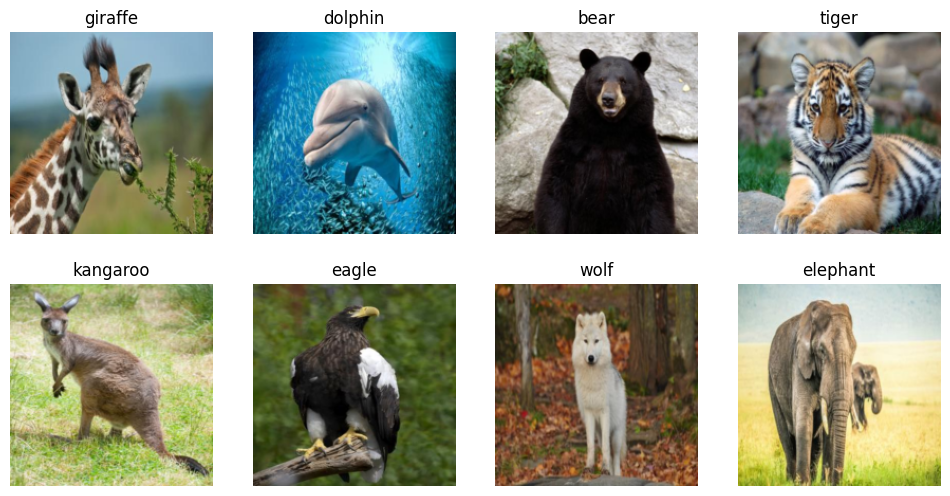

In [8]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=8)

Now we're ready to train our model. The fastest widely used computer vision model is `resnet18`. You can train this in a few minutes, even on a CPU! (On a GPU, it generally yakes under 10 seconds...)

`fastai` comes with a helpful `fine_tune()` method which automatically uses best practices for fine tuning a pre-trained model, so we'll use that.

In [11]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,0.203964,0.065031,0.018987,00:02
1,0.113601,0.038676,0.018987,00:02
2,0.072520,0.032207,0.018987,00:02


Interestingly, although the training and validation losses decrease as expected, the error rate does not improve. It remains at ~98% over the three epochs.

## Step 3: Investigate our results

We'd like to find out what exactly our model is getting wrong, and potentially why. It could be a case of mislabelled or invalid data. To visualise the model mistakes, we can create a *confusion matrix*:

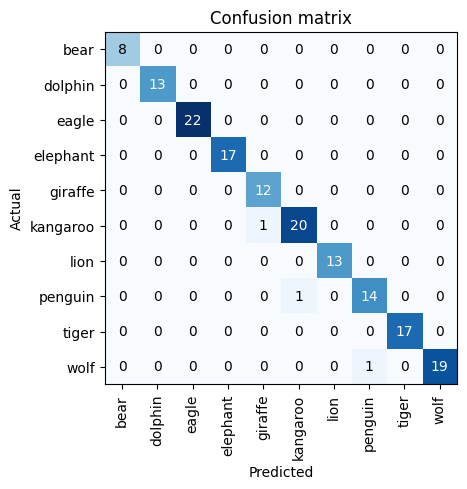

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

The diagonal indicates the number of correct classifications. The off-diagonals indicate misclassifications. From above, we can see that our model made the following three errors:

- One kangaroo misclassified as a giraffe
- One penguin misclassified as a kangaroo
- One wolf misclassified as a penguin

We can check exactly what images caused these misclassifications by sorting the images by their *loss*:

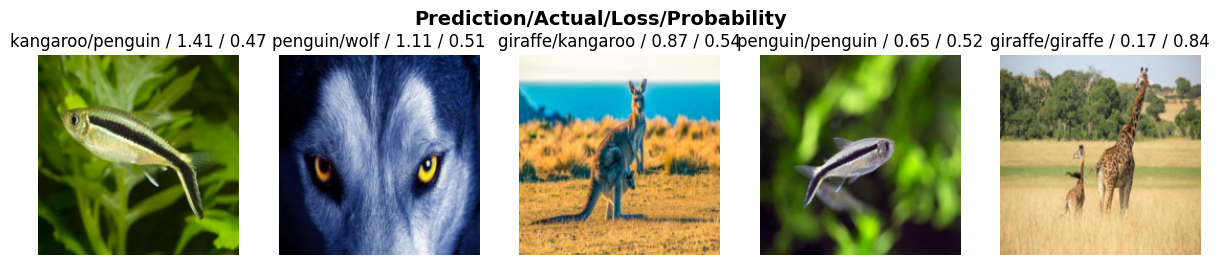

In [14]:
interp.plot_top_losses(5, nrows=1)

Well, then. This explains some things. It appears some of our "penguins" aren't even really penguins -- they're some type of fish? A quick search on DuckDuckGo for our search term "penguin photo" doesn't seem to produce any similar results, nor does the search "penguin fish".

A quick look through the data also shows that we have only 59 images of penguins (including a fair bit of nonsense), compared to 75 to 85 images of every other animal. Looks like we should revise our penguin data.

Let's delete the existing `penguin` folder and try again with a more specific search term.

In [16]:
dest = Path('..', 'data', 'animals', 'penguin')

dest.mkdir(exist_ok=False, parents=True)
download_images(dest, urls=search_images(f'penguin animal'))
resize_images(path/o, max_size=400, dest=path/o)

c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\duckduckgo_search\compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\duckduckgo_search\compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
c:\Users\deren\Git\elec4630\a3\.venv\Lib\site-packages\duckduckgo_search\compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


Again, we'll remove any photos which didn't download properly:

In [17]:
failed = verify_images(get_image_files(dest))
failed.map(Path.unlink)
len(failed)

1

A quick peruse of the data shows that we now have 89 photos of actual penguins.